In [65]:
# analysis of compiled radstats
# initial built: 2025/01/08
# tuned for paper: 2025/03/24
# modified: 2025/09/12 (be cautious about the data selection criteria)
# analyze the model & obs cloud distributions

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [2]:
instrument = 'amsua'
channel    = 'ch1'

expid      = 'v3_hydro'
#expid       = 'old_CTRL_hydro'
#expid       = 'full_CTRL'
#expid       = 'full_CTRL_low_sym'
#expid       = 'full_CTRL_noinf'
#expid       = 'full_only_clr'
#expid      = 'full_clr_cld'
#expid       = 'full_sym'

stdev_from = f'OmF_{expid}'
predictor  = 'sym_cld'

#sdate = '2022062000'
#edate = '2022081000'

sdate = '2024070500'
edate = '2024073012'

save_fig = False
plot_shading_varbc = False # indicates the data that are excluded in VarBC estimate (Zhu et al. 2014)

fig_root  = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/python_codes/figures/'
data_root = f'/gpfs/f6/bil-coastal-gfdl/scratch/Chih-Chi.Hu/compile_radstats/csv_files/'


expshort = {'full_CTRL'      : 'CTRL',
            'full_clr_cld'   : 'CLR-CLD',
            'full_only_clr'  : 'CLR',
            'full_sym_tri'   : 'CLR-CLD_SYM',
            'full_sym_clwnbc': 'POLY_NOBC',
            'full_sym_bc'    : 'POLY_BC',  
            'full_low_sym_tri': 'CLR-CLD_SYM_LOW', 
            'full_CTRL_low_sym': 'CTRL_SYM_LOW',
            'v3_hydro'        : 'hydro'}

expcolor = {'full_CTRL': 'black', 
            'full_only_clr': 'gray', 
            'full_clr_cld' : 'blue', 
            'full_sym_tri' : 'green', 
            'full_low_sym_tri':  'orange', 
            'full_CTRL_low_sym': 'olive', 
            'full_sym_bc':       'brown',
            'full_sym_clwnbc':   'purple'  }


if instrument == 'amsua':
    if channel in ('ch1','ch3'):
        vmin = -30; vmax = 30;
    elif channel in ('ch2'):
        vmin = -45; vmax = 45;
    elif channel in ('ch4'):
        vmin = -7;  vmax = 7;
    elif channel in ('ch5'):
        vmin = -3;  vmax = 3;
    elif channel in ('ch15'):
        vmin = -40; vmax = 40;
            
elif instrument == 'atms':
    if channel in ('ch16'):
        vmin = -30; vmax = 30;
    elif channel in ('ch17','ch18'):
        vmin = -25; vmax = 25;
    elif channel in ('ch19','ch20'):
        vmin = -15; vmax = 15;
    elif channel in ('ch21','ch22'):
        vmin = -20; vmax = 20;
        
    

In [3]:
### read omf csv (large file!)
fn = f'{data_root}/{expid}/omfges_stats_{instrument}_{channel}_{sdate}_{edate}.csv'
df = pd.read_csv(fn)

# screen the data:
dftmp       = df[ (df['errinv']>0) & (df['fwater']>=0.99) ]
#dftmp       = df[ (df['omf']<1e3) &((df['qcmark']==0) | (df['qcmark']==3) | (df['qcmark']==53) | (df['qcmark']==54)) & (df['fwater']>=0.99) ]
dftmp_varbc = df[ (df['errinv']>0) & (df['fwater']>=0.99) & (df['varbc_idx']==1) ]
#dftmp_varbc = df[ (df['omf']<1e3) &((df['qcmark']==0) | (df['qcmark']==3) | (df['qcmark']==53) | (df['qcmark']==54)) & (df['fwater']>=0.99) & (df['varbc_idx']==1)]


In [4]:
# Current cloud proxy used for each channel:
if instrument == 'amsua':
    if channel in ('ch1','ch2','ch3'):
        cld_proxy = 'clw'
    elif channel in ('ch4','ch5','ch15'):
        cld_proxy = 'ch3'
elif instrument == 'atms':
    if channel in ('ch1','ch2','ch3'):
        cld_proxy = 'clw'
    elif channel in ('ch4','ch5','ch6','ch16','ch17'):
        cld_proxy = 'ch3'
    elif channel in ('ch18','ch19','ch20','ch21','ch22'):
        cld_proxy = 'si_ch16_ch17'

In [5]:
# quick check if the selected data is what you want:
dftmp['qcmark'].value_counts()

qcmark
0.0    839354
Name: count, dtype: int64

/tmp/ipykernel_1337887/2860471216.py:55: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist*dA)
/tmp/ipykernel_1337887/2860471216.py:64: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)


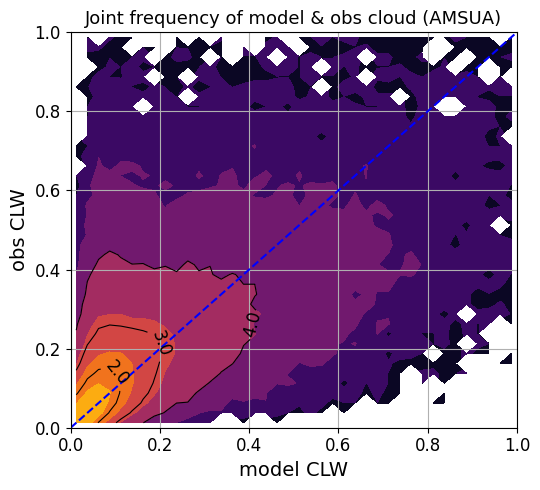

In [7]:
# model cloud vs observation cloud analysis:
# as long as the channel uses the same cloud proxy, the below plots should look very similar

#save_fig = False
fig_dir = f'{fig_root}/model_obs_cloud_analysis/{expid}'

if save_fig:
    os.makedirs(fig_dir, exist_ok=True)
    print(f"Directory '{fig_dir}' created.")

if cld_proxy == 'clw':
    x_edges = np.linspace( 0, 1, 41)  
    y_edges = np.linspace( 0, 1, 41)
    x = dftmp['clw_bg_nobc']; y = dftmp['clw_obs']
elif cld_proxy == 'cldeff':
    x_edges = np.linspace( -20, 20, 41)  
    y_edges = np.linspace( -20, 20, 41)
    x = dftmp['cldeff_bg']; y = dftmp['cldeff_obs']
elif cld_proxy == 'ch3':
    x_edges = np.linspace( 0, 30, 41)  
    y_edges = np.linspace( 0, 30, 41)
    x = dftmp['cld_ch3_bg']; y = dftmp['cld_ch3_obs']
elif cld_proxy == 'lwp+si':
    x_edges = np.linspace( 0, 1.2, 41)  
    y_edges = np.linspace( 0, 1.2, 41)
    x = dftmp['cld_lwpsi_bg']; y = dftmp['cld_lwpsi_obs']
elif cld_proxy == 'si_ch1_ch15':
    x_edges = np.linspace( 0, 30, 41)  
    y_edges = np.linspace( 0, 30, 41)
    x = dftmp['si_1_15_bg']; y = dftmp['si_1_15_obs']
elif cld_proxy == 'si_ch1_ch2_ch15':
    x_edges = np.linspace( 0, 30, 41)  
    y_edges = np.linspace( 0, 30, 41)
    x = dftmp['si_1_2_15_bg']; y = dftmp['si_1_2_15_obs']
elif cld_proxy == 'si_ch16_ch17':
    x_edges = np.linspace( 0, 40, 41)  
    y_edges = np.linspace( 0, 40, 41)
    x = dftmp['si_16_17_bg']; y = dftmp['si_16_17_obs']
else:
    raise ValueError(f" cloud proxy {cld_proxy} is incorrect!!!")  

# generate the joint pdf (histogram)   
dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]
dA = dx*dy

hist, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_edges, y_edges], density=True)

xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])

xx, yy = np.meshgrid(xc, yc)

# Mask values >= 6
input_data = - np.log10(hist*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx, yy, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx, yy, -np.log10(hist*dA).T, levels=[2,3,4], colors='black', linewidths=0.8)

# Add labels to contour lines
ax.clabel(contour_lines, inline=True, fontsize=12, fmt="%.1f")
ax.set_xlabel(f'model {cld_proxy.upper()}',fontsize=14)
ax.set_ylabel(f'obs {cld_proxy.upper()}',fontsize=14)
ax.plot([x_edges[0],x_edges[-1]], [x_edges[0],x_edges[-1]], linestyle='--', color='blue')
ax.set_xlim(x_edges[0], x_edges[-1])
ax.set_ylim(x_edges[0], x_edges[-1])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'Joint frequency of model & obs cloud ({instrument.upper()})',fontsize=13)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/jointpdf_model_obs_{cld_proxy}_{expid}.png', dpi=200, bbox_inches='tight')

In [47]:
dftmp.keys()

Index(['sensor', 'Unnamed: 1', 'lat', 'lon', 'fwater', 'fland', 'obs',
       'clw_obs', 'cldeff_obs', 'cld_ch3_obs', 'cld_lwpsi_obs', 'si_1_15_obs',
       'si_1_2_15_obs', 'si_16_17_obs', 'clw_bg', 'clw_bg_nobc', 'cldeff_bg',
       'cld_ch3_bg', 'cld_lwpsi_bg', 'si_1_15_bg', 'si_1_2_15_bg',
       'si_16_17_bg', 'qcmark', 'symerr', 'errinv', 'omf', 'omfnbc',
       'varbc_idx'],
      dtype='object')

/tmp/ipykernel_1337887/1759055586.py:72: RuntimeWarning: divide by zero encountered in log10
  input_data = - np.log10(hist_diff*dA)
/tmp/ipykernel_1337887/1759055586.py:81: RuntimeWarning: divide by zero encountered in log10
  contour_lines = plt.contour(xx_diff, yy_diff, -np.log10(hist_diff*dA_diff).T, levels=[2,3,4], colors='black', linewidths=0.8)


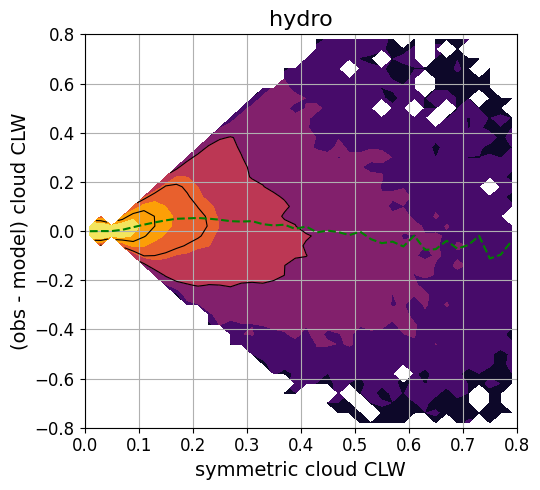

In [8]:
# Plot (obs-model) CLW as a function of symmetric CLW (for paper part II)
# NOTE:: only plot for data with varbc_idx == 1

#save_fig = False
fig_dir = f'{fig_root}/model_obs_cloud_analysis/{expid}'

if save_fig:
    os.makedirs(fig_dir, exist_ok=True)
    print(f"Directory '{fig_dir}' created.")

# whether to show only the data used in VarBC:
use_varbc_data = True

if cld_proxy == 'clw':
    if use_varbc_data:
        sym_cloud = 0.5*(dftmp_varbc['clw_bg'] + dftmp_varbc['clw_obs'])
        x = sym_cloud
        y = dftmp_varbc['clw_obs'] - dftmp_varbc['clw_bg']
    else:
        sym_cloud = 0.5*(dftmp['clw_bg'] + dftmp['clw_obs'])
        x = sym_cloud
        y = dftmp['clw_obs'] - dftmp['clw_bg']

    bin_max = 0.8
    bin_num = 41

elif cld_proxy == 'ch3':
    sym_cloud = 0.5*(dftmp_varbc['cld_ch3_bg'] + dftmp_varbc['cld_ch3_obs'])
    x = sym_cloud
    y = dftmp_varbc['cld_ch3_obs'] - dftmp_varbc['cld_ch3_bg']

    bin_max = 30
    bin_num = 41    
elif cld_proxy == 'si_ch16_ch17':
    sym_cloud = 0.5*(dftmp_varbc['si_16_17_bg'] + dftmp_varbc['si_16_17_obs'])
    x = sym_cloud
    y = dftmp_varbc['si_16_17_obs'] - dftmp_varbc['si_16_17_bg']

    bin_max = 30
    bin_num = 41    

# calculate the conditional mean (takes time...)
xx = np.linspace(0,bin_max,bin_num)
xxc = 0.5*(xx[:-1] + xx[1:])
yyc = np.zeros_like(xxc)
for i in range(len(xxc)):
    if use_varbc_data:
        xdftmp = dftmp_varbc.loc[ (sym_cloud>=xx[i]) & (sym_cloud<xx[i+1]) ]
    else:
        xdftmp = dftmp.loc[ (sym_cloud>=xx[i]) & (sym_cloud<xx[i+1]) ]

    if cld_proxy == 'clw': yyc[i] = xdftmp['clw_obs'].mean() - xdftmp['clw_bg'].mean()
    if cld_proxy == 'ch3': yyc[i] = xdftmp['cld_ch3_obs'].mean() - xdftmp['cld_ch3_bg'].mean()
    if cld_proxy == 'si_ch16_ch17': yyc[i] = xdftmp['si_16_17_obs'].mean() - xdftmp['si_16_17_bg'].mean()

    
# joint pdf:
x_diff_edges = np.linspace(       0, bin_max, bin_num)  
y_diff_edges = np.linspace(-bin_max, bin_max, bin_num)
dx_diff = x_diff_edges[1] - x_diff_edges[0]
dy_diff = y_diff_edges[1] - y_diff_edges[0]
dA_diff = dx*dy

hist_diff, x_edges_out, y_edges_out = np.histogram2d(x, y, bins=[x_diff_edges, y_diff_edges], density=True)

xc_diff = 0.5*(x_diff_edges[:-1] + x_diff_edges[1:])
yc_diff = 0.5*(y_diff_edges[:-1] + y_diff_edges[1:])

xx_diff, yy_diff = np.meshgrid(xc_diff, yc_diff)

# Mask values >= 6
input_data = - np.log10(hist_diff*dA)
input_data_mask = np.ma.masked_where(input_data >= 5.5, input_data)
input_data_mask = input_data

## Plot figure
fig, ax = plt.subplots(figsize=(5.5,5))
contour1=ax.contourf(xx_diff, yy_diff, -input_data_mask.T, cmap='inferno')

# Add contour lines
contour_lines = plt.contour(xx_diff, yy_diff, -np.log10(hist_diff*dA_diff).T, levels=[2,3,4], colors='black', linewidths=0.8)

# plot the conditional mean
ax.plot(xxc,yyc, color='green', linestyle='--')
ax.set_xlim(x_diff_edges[0],x_diff_edges[-1])
ax.set_ylim(y_diff_edges[0],y_diff_edges[-1])
ax.set_xlabel(f'symmetric cloud {cld_proxy.upper()}',fontsize=14)
ax.set_ylabel(f'(obs - model) cloud {cld_proxy.upper()}',fontsize=14)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(f'{expshort[expid]}',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/clouddiff_symcloud_{cld_proxy}_{expid}.png', dpi=200, bbox_inches='tight')


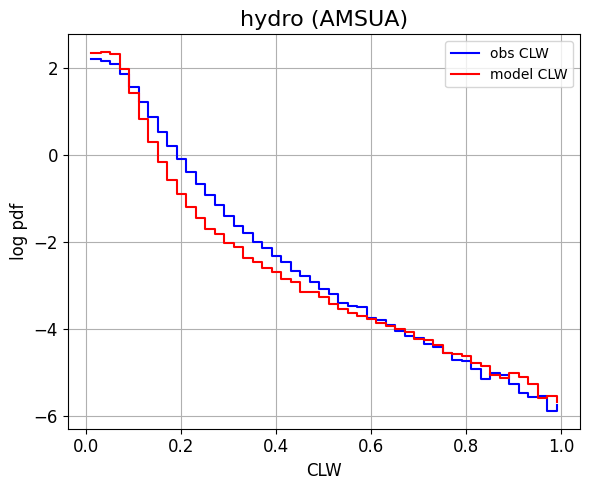

In [9]:
# check the marginal distribution of model & obs cloud proxy

if cld_proxy == 'cldeff':
    dx = 0.1
    bin_max = 2
    bins = np.arange(-bin_max, bin_max+dx, dx)

    cld_obs_pdf, _  = np.histogram(dftmp['cldeff_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['cldeff_bg'], bins=bins)
    #cld_model_pdf, _ = np.histogram(dftmp['cldeff_bg']+1.20*np.random.normal(loc=0, scale=1, size=len(dftmp['cldeff_bg'])), bins=bins)

elif cld_proxy == 'ch3':
    dx = 0.5
    bin_max = 30
    bins = np.arange(0, bin_max+dx, dx)
    
    cld_obs_pdf, _  = np.histogram(dftmp['cld_ch3_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['cld_ch3_bg'], bins=bins)

elif cld_proxy == 'clw':
    dx = 0.02
    bin_max = 1.0
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['clw_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['clw_bg_nobc'], bins=bins)

elif cld_proxy == 'lwp+si':
    dx = 0.02
    bin_max = 1.2
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['cld_lwpsi_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['cld_lwpsi_bg'], bins=bins)

elif cld_proxy == 'si_ch1_ch15':
    dx = 0.5
    bin_max = 20
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['si_1_15_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['si_1_15_bg'], bins=bins)

elif cld_proxy == 'si_ch1_ch2_ch15':
    dx = 0.5
    bin_max = 20
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['si_1_2_15_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['si_1_2_15_bg'], bins=bins)
    
elif cld_proxy == 'si_ch16_ch17':
    dx = 0.5
    bin_max = 20
    bins = np.arange(0, bin_max+dx, dx)
    cld_obs_pdf, _  = np.histogram(dftmp['si_16_17_obs'], bins=bins)
    cld_model_pdf, _ = np.histogram(dftmp['si_16_17_bg'], bins=bins)    
else:
    raise ValueError(f" cloud proxy {cld_proxy} is incorrect!!!")  

bin_center = 0.5*(bins[:-1]+bins[1:])

fig, ax = plt.subplots(figsize=(6,5))
ax.step(bin_center, np.log(cld_obs_pdf/sum(cld_obs_pdf)/dx),     where='post', linestyle='-', color='blue', label=f'obs {cld_proxy.upper()}')
ax.step(bin_center, np.log(cld_model_pdf/sum(cld_model_pdf)/dx),  where='post', linestyle='-', color='red', label=f'model {cld_proxy.upper()}')
ax.grid(True)
ax.set_xlabel(f'{cld_proxy.upper()}', fontsize=12)
ax.set_ylabel('log pdf', fontsize=12)
ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.legend()
ax.set_title(f'{expshort[expid]} ({instrument.upper()})',fontsize=16)
plt.tight_layout()

if save_fig:
    plt.savefig(f'{fig_dir}/marginalpdf_model_obs_{cld_proxy}_{expid}.png', dpi=200, bbox_inches='tight')

In [9]:
## Below are channel-dependent (conditional O-F analysis):

In [10]:
# calculate the conditional mean omf/omfnbc for each model cloud vs observation cloud

# x_edges, y_edges are defined in above block (depending on the cloud proxy)
xc = 0.5*(x_edges[:-1] + x_edges[1:])
yc = 0.5*(y_edges[:-1] + y_edges[1:])
xx, yy = np.meshgrid(xc, yc)

cond_mean_omf    = np.zeros_like(xx) # the conditional mean omf
cond_mean_omf_norm_final = np.zeros_like(xx)
cond_mean_omf_norm_sym   = np.zeros_like(xx)

# generate the conditional mean omf in each (model cloud, obs cloud) box:
for ii in range(len(xc)):
    for jj in range(len(yc)):

        if cld_proxy == 'clw':
            x_edges = np.linspace( 0, 1, 41)  
            y_edges = np.linspace( 0, 1, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['clw_obs'] >= y_edges[jj]) \
                                & (dftmp['clw_obs'] <  y_edges[jj+1]) \
                                & (dftmp['clw_bg_nobc'] >= x_edges[ii]) \
                                & (dftmp['clw_bg_nobc'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))
            cond_mean_omf_norm_sym[ii,jj]   = np.nanmean(cond_df['omf']/(cond_df['symerr']**2))

        elif cld_proxy == 'cldeff':
            x_edges = np.linspace( -2, 2, 41)  
            y_edges = np.linspace( -2, 2, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['cldeff_obs'] >= y_edges[jj]) \
                                & (dftmp['cldeff_obs'] <  y_edges[jj+1]) \
                                & (dftmp['cldeff_bg'] >= x_edges[ii]) \
                                & (dftmp['cldeff_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))
            cond_mean_omf_norm_sym[ii,jj]   = np.nanmean(cond_df['omf']/(cond_df['symerr']**2))

        elif cld_proxy == 'ch3':
            x_edges = np.linspace( 0, 30, 41)  
            y_edges = np.linspace( 0, 30, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['cld_ch3_obs'] >= y_edges[jj]) \
                                & (dftmp['cld_ch3_obs'] <  y_edges[jj+1]) \
                                & (dftmp['cld_ch3_bg'] >= x_edges[ii]) \
                                & (dftmp['cld_ch3_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))
            cond_mean_omf_norm_sym[ii,jj]   = np.nanmean(cond_df['omf']/(cond_df['symerr']**2))

        elif cld_proxy == 'lwp+si':
            x_edges = np.linspace( 0, 1.2, 41)  
            y_edges = np.linspace( 0, 1.2, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['cld_lwpsi_obs'] >= y_edges[jj]) \
                                & (dftmp['cld_lwpsi_obs'] <  y_edges[jj+1]) \
                                & (dftmp['cld_lwpsi_bg'] >= x_edges[ii]) \
                                & (dftmp['cld_lwpsi_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))
            cond_mean_omf_norm_sym[ii,jj]   = np.nanmean(cond_df['omf']/(cond_df['symerr']**2))

        elif cld_proxy == 'si_ch1_ch15':
            x_edges = np.linspace( 0, 20, 41)  
            y_edges = np.linspace( 0, 20, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['si_1_15_obs'] >= y_edges[jj]) \
                                & (dftmp['si_1_15_obs'] <  y_edges[jj+1]) \
                                & (dftmp['si_1_15_bg'] >= x_edges[ii]) \
                                & (dftmp['si_1_15_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))
            cond_mean_omf_norm_sym[ii,jj]   = np.nanmean(cond_df['omf']/(cond_df['symerr']**2))

        elif cld_proxy == 'si_ch1_ch2_ch15':
            x_edges = np.linspace( 0, 20, 41)  
            y_edges = np.linspace( 0, 20, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['si_1_2_15_obs'] >= y_edges[jj]) \
                                & (dftmp['si_1_2_15_obs'] <  y_edges[jj+1]) \
                                & (dftmp['si_1_2_15_bg'] >= x_edges[ii]) \
                                & (dftmp['si_1_2_15_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))
            cond_mean_omf_norm_sym[ii,jj]   = np.nanmean(cond_df['omf']/(cond_df['symerr']**2))

        elif cld_proxy == 'si_ch16_ch17':
            x_edges = np.linspace( 0, 40, 41)  
            y_edges = np.linspace( 0, 40, 41)
            dx = x_edges[1] - x_edges[0]
            dy = y_edges[1] - y_edges[0]
            dA = dx*dy
            
            xc = 0.5*(x_edges[:-1] + x_edges[1:])
            yc = 0.5*(y_edges[:-1] + y_edges[1:])
            xx, yy = np.meshgrid(xc, yc)
            
            cond_df = dftmp.loc[  (dftmp['si_16_17_obs'] >= y_edges[jj]) \
                                & (dftmp['si_16_17_obs'] <  y_edges[jj+1]) \
                                & (dftmp['si_16_17_bg'] >= x_edges[ii]) \
                                & (dftmp['si_16_17_bg'] <  x_edges[ii+1])]
            cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
            cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))
            cond_mean_omf_norm_sym[ii,jj]   = np.nanmean(cond_df['omf']/(cond_df['symerr']**2))


/tmp/ipykernel_1337887/193418607.py:31: RuntimeWarning: Mean of empty slice
  cond_mean_omf[ii,jj]    = np.nanmean(cond_df['omf'])
/tmp/ipykernel_1337887/193418607.py:32: RuntimeWarning: Mean of empty slice
  cond_mean_omf_norm_final[ii,jj] = np.nanmean(cond_df['omf']*(cond_df['errinv']**2))
/tmp/ipykernel_1337887/193418607.py:33: RuntimeWarning: Mean of empty slice
  cond_mean_omf_norm_sym[ii,jj]   = np.nanmean(cond_df['omf']/(cond_df['symerr']**2))


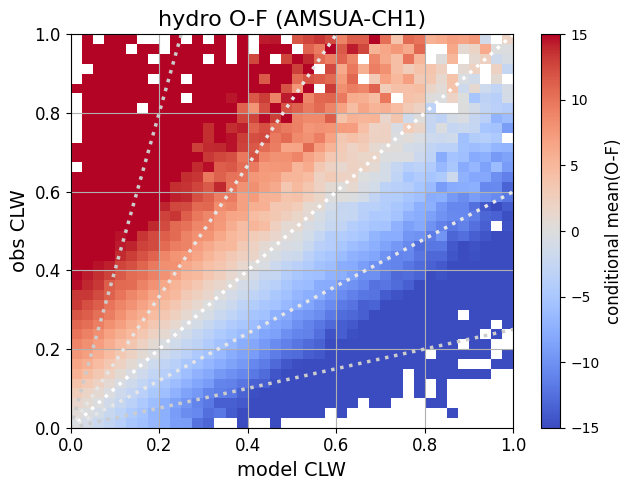

In [11]:
# Plot the conditional mean omf/omfnbc for each model cloud vs observation cloud

#save_fig = False
fig_dir = f'{fig_root}/model_obs_cloud_analysis/{expid}/{instrument}_{channel}'

if save_fig:
    os.makedirs(fig_dir, exist_ok=True)
    print(f"Directory '{fig_dir}' created.")

if instrument =='amsua':
    if channel in ('ch1','ch3','ch15'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 2.5;
    elif channel in ('ch5'):
        #vmax = 1
        vmax = 0.5
elif instrument=='atms':
    if channel in ('ch1','ch3'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 8; 
    elif channel in ('ch5'):
        vmax = 2.5;
    elif channel in ('ch6'):
        vmax = 1
    if channel in ('ch16','N/A'):
        vmax = 20
    elif channel in ('ch17','N/A'):
        vmax = 15
    elif channel in ('ch18','N/A'):
        vmax = 12
    elif channel in ('ch19','N/A'):
        vmax = 7
    elif channel in ('ch20','ch21','ch22'):
        vmax = 3

vmin=-vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label('conditional mean(O-F)', fontsize=12)
ax.set_xlabel(f'model {cld_proxy.upper()}',fontsize=14)
ax.set_ylabel(f'obs {cld_proxy.upper()}',fontsize=14)
ax.set_xlim(x_edges[0],x_edges[-1])
ax.set_ylim(y_edges[0],y_edges[-1])

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points

width_help_lines = 2.5

val_min = x_edges[0]; val_max = x_edges[-1]
ax.plot([val_min,val_max], [val_min,val_max],      linestyle=':',  color=(1,1,1), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.6],    linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.25],   linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.6],  linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.25], linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)

ax.grid(True)
ax.set_title(f'{expshort[expid]} O-F ({instrument.upper()}-{channel.upper()})',fontsize=16)

plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_omf_{cld_proxy}_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')
    #plt.savefig(f'{fig_dir}/cond_mean_omf_{cld_proxy}_{instrument}_{channel}_{expid}_no_convection.png', dpi=200, bbox_inches='tight')


/tmp/ipykernel_1337887/1118510331.py:66: RuntimeWarning: divide by zero encountered in log10
  contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5], colors=(1,1,1), linewidths=4)


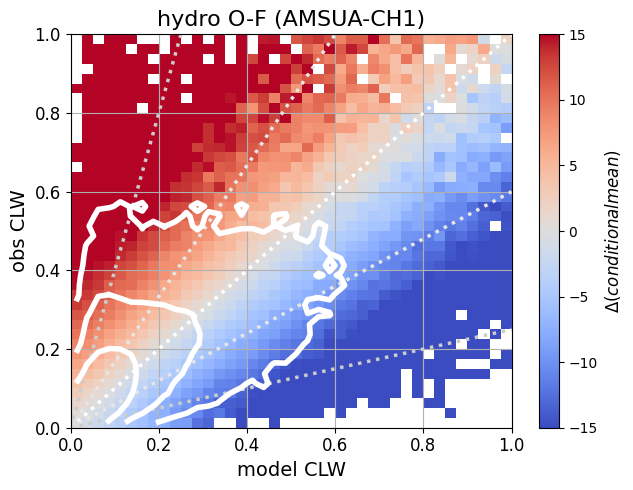

In [12]:
# Plot the conditional mean omf/omfnbc for each model cloud vs observation cloud (with PDF)

#save_fig = False
fig_dir = f'{fig_root}/model_obs_cloud_analysis/{expid}/{instrument}_{channel}'

if save_fig:
    os.makedirs(fig_dir, exist_ok=True)
    print(f"Directory '{fig_dir}' created.")

if instrument =='amsua':
    if channel in ('ch1','ch3','ch15'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 2.5;
    elif channel in ('ch5'):
        vmax = 1
elif instrument=='atms':
    if channel in ('ch1','ch3'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 8; 
    elif channel in ('ch5'):
        vmax = 2.5;
    elif channel in ('ch6'):
        vmax = 1
    if channel in ('ch16'):
        vmax = 20
    elif channel in ('ch17'):
        vmax = 15
    elif channel in ('ch18','ch19'):
        vmax = 3
    elif channel in ('ch20','ch21','ch22'):
        vmax = 1.5
vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'$\Delta(conditional mean)$', fontsize=12)

ax.set_xlim(x_edges[0],x_edges[-1])
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel(f'model {cld_proxy.upper()}',fontsize=14)
ax.set_ylabel(f'obs {cld_proxy.upper()}',fontsize=14)

width_help_lines = 2.5
val_min = x_edges[0]; val_max = x_edges[-1]
ax.plot([val_min,val_max], [val_min,val_max],      linestyle=':',  color=(1,1,1), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.6],    linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.25],   linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.6],  linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.25], linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)

# Add contour lines
contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5], colors=(1,1,1), linewidths=4)

if plot_shading_varbc:
    # Add shaded region:
    ax.fill([0.05, 0.05, 1.00, 1.00],   # X-coordinates of the rectangle
            [0.00, 0.05, 0.05, 0.00],   # Y-coordinates of the rectangle
            color='black', alpha=0.65)  # Fill color and transparency
    
    ax.fill([0.00, 0.05, 0.05, 0.00],   # X-coordinates of the rectangle
            [0.05, 0.05, 1.00, 1.00],   # Y-coordinates of the rectangle
            color='black', alpha=0.65)  # Fill color and transparency


ax.set_title(f'{expshort[expid]} O-F ({instrument.upper()}-{channel.upper()})',fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_omf_withpdf_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')


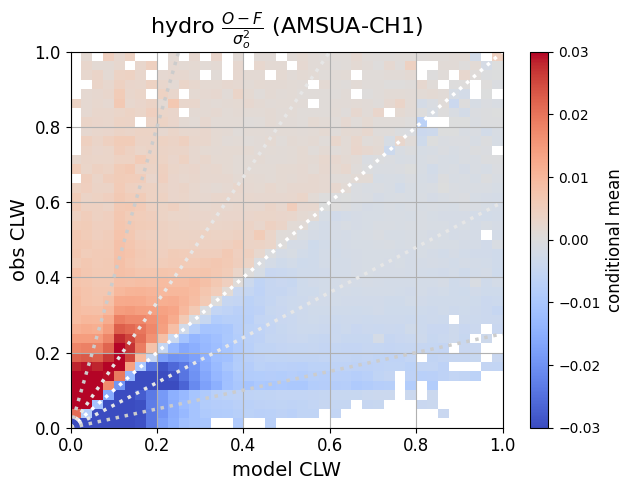

In [13]:
# Plot the conditional mean omf/R for each model cloud vs observation cloud (without PDF)

#save_fig = False
fig_dir = f'{fig_root}/model_obs_cloud_analysis/{expid}/{instrument}_{channel}'

if save_fig:
    os.makedirs(fig_dir, exist_ok=True)
    print(f"Directory '{fig_dir}' created.")

if 'noinf' in expid:
    if channel in ('ch4'):
        vmax = 1.2
    elif channel in ('ch5'):
        vmax = 2
    elif channel in ('ch15'):
        vmax = 0.15
    else:
        vmax = 0.25
else:
    if channel in ('ch4','ch5'):
        vmax = 0.15
    else:
        vmax = 0.03

vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_final.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)
#contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_sym.T, cmap='RdBu_r', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'conditional mean', fontsize=12)
ax.set_xlim(x_edges[0],x_edges[-1])
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel(f'model {cld_proxy.upper()}',fontsize=14)
ax.set_ylabel(f'obs {cld_proxy.upper()}',fontsize=14)


width_help_lines = 2.5
val_min = x_edges[0]; val_max = x_edges[-1]
ax.plot([val_min,val_max], [val_min,val_max],      linestyle=':',  color=(1,1,1), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.6],    linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.25],   linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.6],  linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.25], linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(rf"{expshort[expid]} $\frac{{O-F}}{{\sigma_o^2}}$ ({instrument.upper()}-{channel.upper()})",fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_omfnorm_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_1337887/4133264256.py:51: RuntimeWarning: divide by zero encountered in log10
  contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5], colors=(1,1,1), linewidths=4)


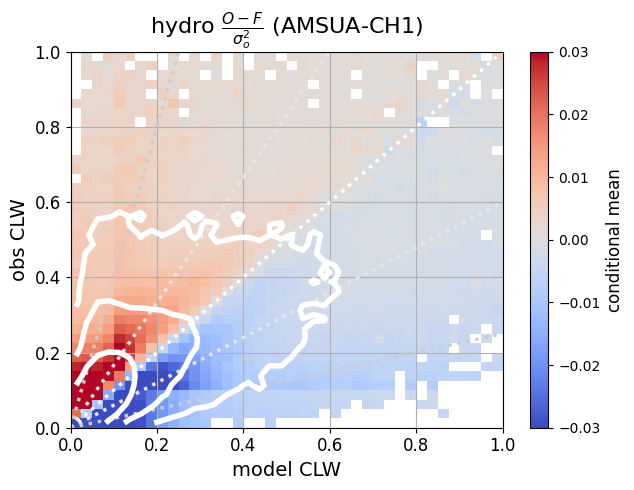

In [14]:
# Plot the conditional mean omf/R for each model cloud vs observation cloud (with PDF)

#save_fig = False
fig_dir = f'{fig_root}/model_obs_cloud_analysis/{expid}/{instrument}_{channel}'

if save_fig:
    os.makedirs(fig_dir, exist_ok=True)
    print(f"Directory '{fig_dir}' created.")

if 'noinf' in expid:
    if channel in ('ch4'):
        vmax = 1.2
    elif channel in ('ch5'):
        vmax = 2
    elif channel in ('ch15'):
        vmax = 0.15
    else:
        vmax = 0.25
else:
    if channel in ('ch4','ch5'):
        vmax = 0.15
    else:
        vmax = 0.03

vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_final.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)
#contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_sym.T, cmap='RdBu_r', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'conditional mean', fontsize=12)

ax.set_xlim(x_edges[0],x_edges[-1])
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel(f'model {cld_proxy.upper()}',fontsize=14)
ax.set_ylabel(f'obs {cld_proxy.upper()}',fontsize=14)


width_help_lines = 2.5
val_min = x_edges[0]; val_max = x_edges[-1]
ax.plot([val_min,val_max], [val_min,val_max],      linestyle=':',  color=(1,1,1), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.6],    linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.25],   linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.6],  linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.25], linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)

# Add contour lines
contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5], colors=(1,1,1), linewidths=4)

if plot_shading_varbc:
    # Add shaded region:
    ax.fill([0.05, 0.05, 1.00, 1.00],   # X-coordinates of the rectangle
            [0.00, 0.05, 0.05, 0.00],   # Y-coordinates of the rectangle
            color='black', alpha=0.65)  # Fill color and transparency
    
    ax.fill([0.00, 0.05, 0.05, 0.00],   # X-coordinates of the rectangle
            [0.05, 0.05, 1.00, 1.00],   # Y-coordinates of the rectangle
            color='black', alpha=0.65)  # Fill color and transparency

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)
ax.set_title(rf"{expshort[expid]} $\frac{{O-F}}{{\sigma_o^2}}$ ({instrument.upper()}-{channel.upper()})",fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_omfnorm_withpdf_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')

/tmp/ipykernel_1337887/3589027690.py:69: RuntimeWarning: divide by zero encountered in log10
  contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5], colors=(1,1,1), linewidths=4)


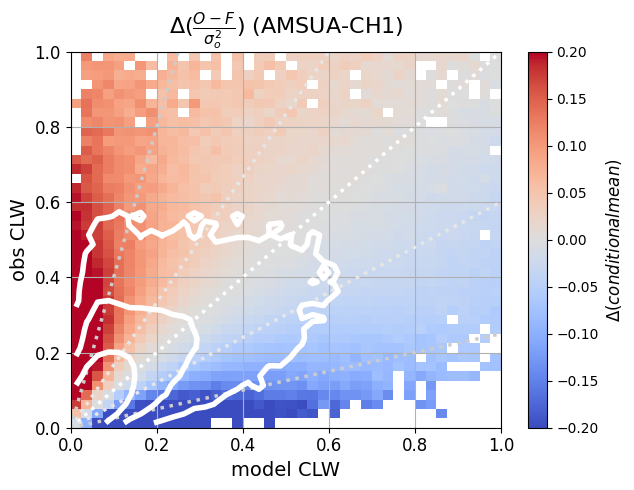

In [15]:
# Plot the difference of conditional mean omf/R for each model cloud vs observation cloud (without PDF)
#          (due to empirical inflation)

#save_fig = False
fig_dir = f'{fig_root}/model_obs_cloud_analysis/{expid}/{instrument}_{channel}'

if save_fig:
    os.makedirs(fig_dir, exist_ok=True)
    print(f"Directory '{fig_dir}' created.")

if instrument =='amsua':
    if channel in ('ch1','ch3','ch15'):
        vmax = 0.2; 
    elif channel in ('ch2'):
        vmax = 0.2; 
    elif channel in ('ch4'):
        vmax = 1.5;
    elif channel in ('ch5'):
        vmax = 1.5;
elif instrument=='atms':
    if channel in ('ch1','ch3'):
        vmax = 15; 
    elif channel in ('ch2'):
        vmax = 30; 
    elif channel in ('ch4'):
        vmax = 8; 
    elif channel in ('ch5'):
        vmax = 2.5;
    elif channel in ('ch6'):
        vmax = 1
    if channel in ('ch16'):
        vmax = 0.2
    elif channel in ('ch17'):
        vmax = 0.2
    elif channel in ('ch18','ch19'):
        vmax = 0.5
    elif channel in ('ch20','ch21','ch22'):
        vmax = 0.2
vmin = -vmax

## Plot figure
fig, ax = plt.subplots(figsize=(6.5,5))
contour1=ax.pcolormesh(xx, yy, cond_mean_omf_norm_sym.T - cond_mean_omf_norm_final.T, cmap='coolwarm', shading='auto', vmin=vmin, vmax=vmax)

# Add the colorbar
cbar = fig.colorbar(contour1, ax=ax)
cbar.set_label(r'$\Delta(conditional mean)$', fontsize=12)


ax.set_xlim(x_edges[0],x_edges[-1])
ax.set_ylim(y_edges[0],y_edges[-1])
ax.set_xlabel(f'model {cld_proxy.upper()}',fontsize=14)
ax.set_ylabel(f'obs {cld_proxy.upper()}',fontsize=14)


width_help_lines = 2.5
val_min = x_edges[0]; val_max = x_edges[-1]
ax.plot([val_min,val_max], [val_min,val_max],      linestyle=':',  color=(1,1,1), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.6],    linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max*0.25],   linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.6],  linestyle=':',  color=(0.9,0.9,0.9), linewidth=width_help_lines)
ax.plot([val_min,val_max], [val_min,val_max/0.25], linestyle=':',  color=(0.8,0.8,0.8), linewidth=width_help_lines)

ax.tick_params(axis='x', labelsize=12)  # Set the size to 14 points
ax.tick_params(axis='y', labelsize=12)  # Set the size to 14 points
ax.grid(True)

# Add contour lines
contour_lines = ax.contour(xx, yy, -np.log10(hist*dA).T, levels=[2.5,3.5,4.5], colors=(1,1,1), linewidths=4)

if plot_shading_varbc:
    # Add shaded region:
    ax.fill([0.05, 0.05, 1.00, 1.00],   # X-coordinates of the rectangle
            [0.00, 0.05, 0.05, 0.00],   # Y-coordinates of the rectangle
            color='black', alpha=0.65)  # Fill color and transparency
    
    ax.fill([0.00, 0.05, 0.05, 0.00],   # X-coordinates of the rectangle
            [0.05, 0.05, 1.00, 1.00],   # Y-coordinates of the rectangle
            color='black', alpha=0.65)  # Fill color and transparency

ax.set_title(rf"$\Delta (\frac{{O-F}}{{\sigma_o^2}})$ ({instrument.upper()}-{channel.upper()})",fontsize=16)
plt.tight_layout()
if save_fig:
    plt.savefig(f'{fig_dir}/cond_mean_domfnorm_noinfla_{instrument}_{channel}_{expid}.png', dpi=200, bbox_inches='tight')